In [274]:
from sklearn.model_selection import StratifiedKFold
import polars as pl
import numpy as np

TARGET = 'Label_Int'
CLUSTERS = 3

def fetch_data(df, use_split):
    assert(use_split >= 0 and use_split <= 4)
    # perform 5-fold cross validation with a deterministic seed
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2028)
    split_x, split_y = get_x_y(df)
    splits = list(kf.split(split_x, split_y))

    # indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    return df_train, df_test

def get_x_y(df):
    df = df.drop("Label")
    X, y = df.drop(TARGET).to_numpy(), df.get_column(TARGET)
    return X, y.to_numpy()

df = pl.read_csv('iris.data', has_header=False)
df = df.rename({"column_5": "Label"})
df = df.with_columns(pl.col("Label").cast(pl.Categorical).to_physical().alias(TARGET))
df_train, df_test = fetch_data(df, 1)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
df_train.tail()

column_1,column_2,column_3,column_4,Label,Label_Int
f64,f64,f64,f64,str,u32
6.8,3.2,5.9,2.3,"""Iris-virginica...",2
6.7,3.3,5.7,2.5,"""Iris-virginica...",2
6.3,2.5,5.0,1.9,"""Iris-virginica...",2
6.5,3.0,5.2,2.0,"""Iris-virginica...",2
5.9,3.0,5.1,1.8,"""Iris-virginica...",2


In [275]:
ID_TO_NAME = {}
NAME_TO_ID = {}
for p in df.partition_by("Label"):
    label = p.row(0)[-2]
    id = p.row(0)[-1]
    ID_TO_NAME[id] = label
    NAME_TO_ID[label] = id
ID_TO_NAME

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

In [276]:
from sklearn.cluster import KMeans
import numpy as np

model = KMeans(n_clusters=CLUSTERS, random_state=2028, n_init=10)
model.fit(X_train)

preds = model.predict(X_test)
np.count_nonzero(preds == y_test) / len(y_test)

0.9

In [277]:
import numpy as np
from numpy.random import Generator, PCG64
import random

def euclidean(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2, axis=1))

# for each point, find the closest centroid & assign to a cluster
def assign_clusters(X, centroids):
    return [np.argmin(euclidean(x, centroids)) for x in X]

def score_clusters(X, centroids):
    return sum([np.min(euclidean(x, centroids)) for x in X])
    
# update the centroids
def update_centroids(X, clusters):
    centroids = []

    for c in set(clusters):
        cluster = X[np.where(clusters == c)[0]]
        mean = cluster.mean(axis=0)
        centroids.append(mean)
    return centroids

# initialize centroids using kmeans++ method
def initialize_centroids(X, n_clusters, seed):
    # randomly initialize one centroid.
    gen = Generator(PCG64(seed=seed))
    centroids = [gen.choice(X_train)]

    for _ in range(n_clusters - 1):
        distances = np.sum([euclidean(X_train, centroid) for centroid in centroids], axis=0)            
        distances /= np.sum(distances) # normalize

        # choose centroids probabilistically based on distance
        centroid_idx = gen.choice(range(len(X_train)), size=1, p=distances)[0]
        centroids += [X_train[centroid_idx]]
    return centroids

class K_Means():
    def __init__(self, n_clusters, epochs=350, seed=482023, n_init=10):
        self.n_clusters = n_clusters
        self.epochs = epochs
        self.centroids = []
        self.seed = seed
        self.n_init = n_init

    def fit(self, X):
        self.centroids = initialize_centroids(X, self.n_clusters, self.seed)
        best_score = 1e10
        epsilon = 1e-4
        # Following sklearn, perform multiple initializations, choose the best based on total distance from cluster centers
        for init in range(self.n_init):
            centroids = initialize_centroids(X, self.n_clusters, self.seed + init)
            clusters = assign_clusters(X, centroids)
            centroids = update_centroids(X, clusters)
            last_score = 1e10
            for _ in range(self.epochs):
                clusters = assign_clusters(X, centroids)
                centroids = update_centroids(X, clusters)
                score = score_clusters(X, centroids)
                # Abort early if clusters do not change
                if abs(score - last_score) < epsilon:
                    break
                last_score = score 
            if score < best_score:
                self.centroids = centroids
                self.clusters = clusters
            
    
    def predict(self, X):
        return np.array(assign_clusters(X, self.centroids))
    
def reassign(preds, actual):
    '''Map each cluster to its majority label in the data, correcting arbitrary label values'''
    assignment = np.zeros_like(preds)
    for i in range(CLUSTERS):
        # Select real labels of cluster
        select = actual[(preds == i).nonzero()]
        # Return mode
        mode = 0
        mode_count = -1
        for c in range(CLUSTERS):
            total = (select == c).sum()
            if total > mode_count:
                mode_count = total 
                mode = c
        assignment[(preds == i).nonzero()] = mode
    return assignment

model = K_Means(n_clusters=CLUSTERS) 
model.fit(X_train)

preds = model.predict(X_test)
preds = reassign(preds, y_test)
np.count_nonzero(preds == y_test) / len(y_test)

0.9

In [278]:
def run_experiment(df, use_split):
    df_train, df_test = fetch_data(df, use_split)
    X_train, _ = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = K_Means(n_clusters=CLUSTERS) 
    model.fit(X_train) 
    preds = model.predict(X_test)
    preds = reassign(preds, y_test)
    return len(y_test) - np.count_nonzero(preds == y_test)

def sk_bench(df, use_split):
    df_train, df_test = fetch_data(df, use_split)
    X_train, _ = get_x_y(df_train)
    X_test, y_test = get_x_y(df_test)
    model = KMeans(n_clusters=CLUSTERS, random_state=2028, n_init=10)
    model.fit(X_train)
    preds = model.predict(X_test)
    preds = reassign(preds, y_test)
    return len(y_test) - np.count_nonzero(preds == y_test)

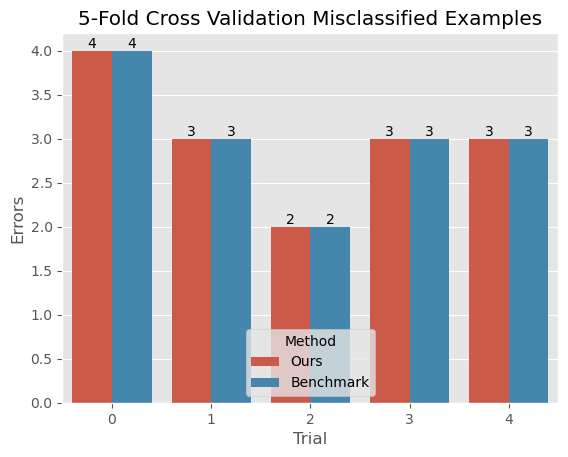

In [279]:
import seaborn
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
COLORS = seaborn.color_palette()
f, ax = plt.subplots()

our_method = [run_experiment(df, x) for x in range(5)]
benchmark = [sk_bench(df, x) for x in range(5)]
method = ['Ours' for _ in range(5)] + ['Benchmark' for _ in range(5)]
plot_df = pd.DataFrame.from_dict({'Errors': our_method + benchmark, 'Method': method, 'Trial': list(range(5)) + list(range(5))})
ax.set_title('5-Fold Cross Validation Misclassified Examples')
seaborn.barplot(data=plot_df, x='Trial', y='Errors', hue='Method', ax=ax, palette=COLORS)
seaborn.move_legend(ax, "lower center")
for container in ax.containers:
    ax.bar_label(container)

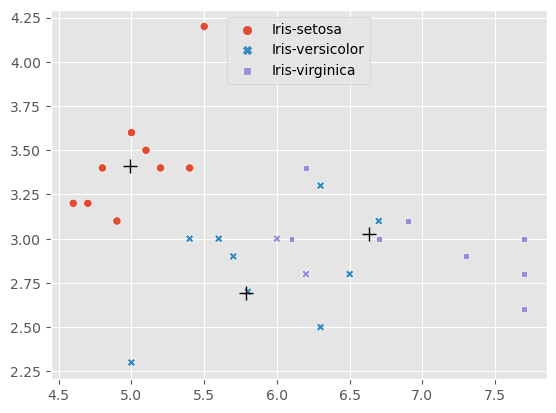

In [280]:
import seaborn 
import matplotlib.pyplot as plt

plt.style.use('ggplot')
COLORS = seaborn.color_palette()

plt.figure()
ax = seaborn.scatterplot(
    x=[X[0] for X in X_test], y=[X[1] for X in X_test], hue=y_test,
    style=preds, palette=COLORS[0:3], legend='full')
plt.plot(
    [x for x, _, _, _ in model.centroids], [y for _, y, _, _ in model.centroids], '+',
    markersize=10, c='black')
h, _ = ax.get_legend_handles_labels()
labels = [ID_TO_NAME[x] for x in range(3)]
plt.legend(handles=h, loc='upper center', labels=labels)
plt.show()

In [273]:
from sklearn.mixture import GaussianMixture
df_train, df_test = fetch_data(df, 1)
X_train, y_train = get_x_y(df_train)
X_test, y_test = get_x_y(df_test)
mix = GaussianMixture(n_components=3, covariance_type="full")
mix.fit(X_train, y_train)
mix_preds = mix.predict(X_test)
mix_preds = reassign(mix_preds, y_test)
np.count_nonzero(mix_preds == y_test) / len(y_test)
mix.means_
np.abs(mix.covariances_).min()
mix.weights_

array([0.35666317, 0.33333333, 0.3100035 ])

In [281]:
def normal_pdf(x, mu, sigma):
    k = len(mu)
    # Assume x, mu are row vectors 
    denom1 = np.sqrt((2 * np.pi)**k * np.linalg.det(sigma))
    try:
        mat1 = np.matmul((x - mu).T, np.linalg.inv(sigma)) 
    except Exception:
        print(sigma)
        raise(ArithmeticError)
    num1 = np.exp(-0.5 * np.matmul(mat1, (x - mu)))
    return num1 / denom1

class Mixture:
    def __init__(self, mu, sigma, pi):
        self.n_classes = len(mu)
        self.mu = mu 
        self.sigma = sigma
        # self.pi = np.ones(self.n_classes, dtype=np.float64) / self.n_classes
        self.pi = pi

    def fit(self, X, steps=20):
        # print(X.shape)
        print(self.pi)
        print(self.mu)
        print(self.sigma)
        # print("Printing mu: ")
        # print(self.mu)
        # print(self.sigma[0])
        N = X.shape[0]
        resp = np.zeros((N, self.n_classes))

        for _ in range(steps):

            # E Step
            for i in range(N):
                x = X[i]
                resp[i, :] = self.responsibility(x)
            # M Step
            n_ks = np.sum(resp, axis=0)
            # print(n_ks)
            # Update Mu
            for k in range(self.n_classes):
                total = np.zeros_like(self.mu[0])
                for i in range(N):
                    total += resp[i, k] * X[i]
                total /= n_ks[k]
                # print("Printing total: ")
                # print(total)
                self.mu[k] = total
            # Update Sigma
            for k in range(self.n_classes):
                total = np.zeros_like(self.sigma[0])
                mean = self.mu[k]
                for i in range(N):
                    x = X[i]
                    size = x.size
                    # We are using row vectors, so the transpose is reversed
                    a = np.reshape(x - mean, (size, 1))
                    b = np.reshape(x - mean, (1, size))
                    val = resp[i, k] * np.matmul(a, b)
                    # print(val)
                    total += val
                total /= n_ks[k]
                self.sigma[k] = total
            # Update Pi
            self.pi = n_ks / N
            # print(self.pi)
            # print(self.sigma[-1])
        print(self.pi)
        print(self.mu)
        print(self.sigma)
        

    def responsibility(self, x):
        nums = [self.pi[i] * normal_pdf(x, self.mu[i], self.sigma[i]) for i in range(self.n_classes)]
        total = sum(nums)
        return np.array(nums) / total

In [282]:
centroids = [np.copy(x) for x in model.centroids]
clusters = np.array(model.clusters)
pi = np.array([(clusters == i).sum() for i in range(CLUSTERS)]) / len(clusters)
# variance = [np.cov(X_train[clusters == i].T) for i in range(CLUSTERS)]
variance = [np.cov(X_train.T) for _ in range(CLUSTERS)]
# v = variance[0] + variance[1] + variance[2]
# v = [v, v, v]

mix = Mixture(centroids, variance, pi)
mix.fit(X_train)

[0.33333333 0.34166667 0.325     ]
[array([4.9925, 3.4125, 1.465 , 0.25  ]), array([6.63658537, 3.02439024, 5.5097561 , 1.97560976]), array([5.78461538, 2.69230769, 4.20512821, 1.33589744])]
[array([[ 0.64759384, -0.01835434,  1.21804622,  0.49546639],
       [-0.01835434,  0.20183123, -0.30223739, -0.11040966],
       [ 1.21804622, -0.30223739,  3.05026261,  1.27456933],
       [ 0.49546639, -0.11040966,  1.27456933,  0.5754895 ]]), array([[ 0.64759384, -0.01835434,  1.21804622,  0.49546639],
       [-0.01835434,  0.20183123, -0.30223739, -0.11040966],
       [ 1.21804622, -0.30223739,  3.05026261,  1.27456933],
       [ 0.49546639, -0.11040966,  1.27456933,  0.5754895 ]]), array([[ 0.64759384, -0.01835434,  1.21804622,  0.49546639],
       [-0.01835434,  0.20183123, -0.30223739, -0.11040966],
       [ 1.21804622, -0.30223739,  3.05026261,  1.27456933],
       [ 0.49546639, -0.11040966,  1.27456933,  0.5754895 ]])]
[0.33333333 0.35655845 0.31010821]
[array([4.9925, 3.4125, 1.465 , 0.2

In [245]:
from scipy.stats import multivariate_normal
multivariate_normal(centroids[0], variance[0]).pdf(X_train[0])

18.27473859514806

In [246]:
normal_pdf(X_train[0], centroids[0], variance[0])

18.274738595148072